## **1. Prepare Environment**
---

In [1]:
#@markdown ##Install packages which are not included in Google Colab.
%tensorflow_version 1.x
!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install stardist # contains tools to operate STARDIST.
!pip install gputools
!pip install edt
!pip install wget

TensorFlow 1.x selected.


## **2. Import Functions**
---


In [2]:
#@markdown ##Import functions.
# ------- Variable specific to Stardist -------
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D # import objects
from stardist.matching import matching_dataset
from __future__ import print_function, unicode_literals, absolute_import, division
from csbdeep.utils import Path, normalize, download_and_extract_zip_file, plot_history # for loss plot
from csbdeep.io import save_tiff_imagej_compatible
import numpy as np
np.random.seed(42)
lbl_cmap = random_label_cmap()
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ------- Common variable to all notebooks -------
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm 
import datetime

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")


Using TensorFlow backend.


Libraries installed


## **3. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelator: GPU** *(Graphics processing unit)*

In [3]:
#@markdown ##Check GPU.

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
else:
  print('You have GPU access')
  !nvidia-smi

You have GPU access
Fri Jun 19 07:06:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |    265MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                    

##**4. Connect your Google Drive to Colab**
---
 * Click on the URL. 

* Sign in your Google Account. 
* Copy the authorization code. 
* Enter the authorization code. 

* Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

In [4]:
#@markdown ##Connect!
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**5. Parameters and Paths**
---
<font size = 4>**`n_rays`:** Set number of rays (corners) used for Stardist (for instance square has 4 corners).  

<font size = 4>**`n_epochs`:** Input how many epochs (rounds) the network will be trained.

<font size = 4>**`number_of_steps`:** Define the number of training steps by epoch. 

In [5]:
# input imgs folder
Training_images = "/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/images" #@param {type:"string"}
open_images_path = Training_images + "/*.tif"

Training_masks = "/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/masks" #@param {type:"string"}
open_masks_path = Training_masks + "/*.tif"

#open_images_path = '/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/images/*.tif'
#open_masks_path = '/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/masks/*.tif'

# trained model
model_name = 'Fishn32e50s10resize5' #@param {type:"string"}
model_basedir = '/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/models' #@param {type:"string"}

# GPU accelerate
want_gpu = True #@param {type:"boolean"}

# training setting
num_of_rays = 32 #@param {type:"number"} # 32 is a good default choice 
n_epochs = 50 #@param {type:"number"} # default 400
n_steps_per_epoch = 10 #@param {type:"number"} # default 100


##**6. Load Datas**
---


100%|██████████| 20/20 [00:00<00:00, 81.63it/s]


number of images:  20
- training:        17
- validation:       3
Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convol

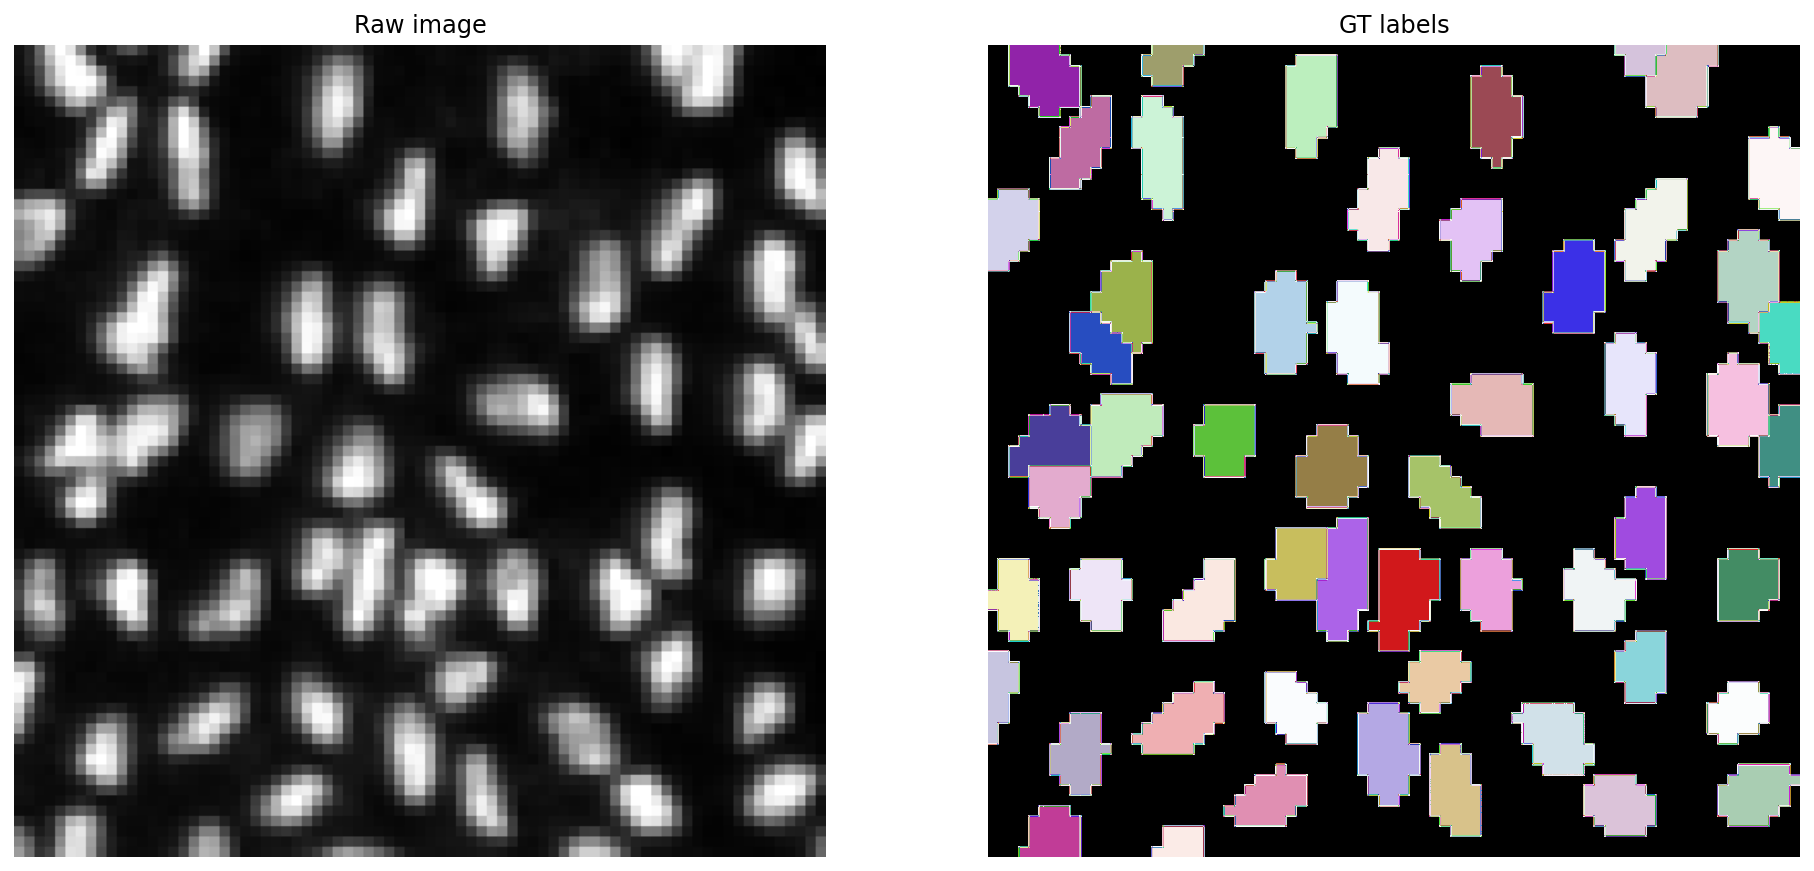

In [15]:
#@markdown ##Load datas.

import warnings
warnings.filterwarnings("ignore")

# Load data
X = sorted(glob(open_images_path))
Y = sorted(glob(open_masks_path))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

# Normalize images and fill small label holes.
axis_norm = (0,1)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

# Split into train and validation datasets.
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

#Training data consists of pairs of input image and label instances.
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Configuration
# A `StarDist2D` model is specified via a `Config2D` object.
print(Config2D.__doc__)

n_rays = num_of_rays

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = want_gpu and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    print("use GPU")

# The trained model will *not predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).
model = StarDist2D(conf, name=model_name, basedir=model_basedir)

# Check if the neural network has a large enough field of view to see up to the boundary of most objects.
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

def random_fliprot(img, mask): 
    axes = tuple(range(img.ndim)) 
    perm = np.random.permutation(axes)
    img = img.transpose(perm) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    return x, y

##**7. Train The Model**
---


In [7]:
#@markdown ##Start Training.

import warnings
warnings.filterwarnings("ignore")

starttime = datetime.datetime.now()
start = time.time()
print('Start', end=' : ')
print(starttime)

# Training the model. 
history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                      epochs=n_epochs, steps_per_epoch=n_steps_per_epoch)

# convert the history.history dict to a pandas DataFrame:     
lossData = pd.DataFrame(history.history) 

if os.path.exists(model_basedir+"/"+model_name+"/Quality Control"):
  shutil.rmtree(model_basedir+"/"+model_name+"/Quality Control")

os.makedirs(model_basedir+"/"+model_name+"/Quality Control")

# The training evaluation.csv is saved (overwrites the Files if needed). 
lossDataCSVpath = model_basedir+'/'+model_name+'/Quality Control/training_evaluation.csv'
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history.history['lr'][i]])

#Here we optimize the network.
model.optimize_thresholds(X_val, Y_val)

# Displaying the time elapsed for training
endtime = datetime.datetime.now()
print('Start', end=' : ')
print(starttime)
print('  End', end=' : ')
print(endtime)

dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

Start : 2020-06-19 07:07:30.807522
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Epoch 1/50
10/10 [==============================] - 4s 356ms/step - loss: 3.3655 - prob_loss: 0.5928 - dist_loss: 13.8622 - prob_kld: 0.4076 - dist_relevant_mae: 13.9067 - dist_relevant_mse: 265.4056 - val_loss: 3.3068 - val_prob_loss: 0.4693 - val_dist_loss: 14.1878 - val_prob_kld: 0.2817 - val_dist_relevant_mae: 14.1878 - val_dist_relevant_mse: 281.9900



Epoch 2/50
10/10 [==============================] - 2s 167ms/step - loss: 3.1651 - prob_loss: 0.4545 - dist_loss: 13.5537 - prob_kld: 0.2803 - dist_relevant_mae: 13.5415 - dist_relevant_mse: 254.7328 - val_loss: 3.1778 - val_prob_loss: 0.4029 - val_dist_loss: 13.8748 - val_prob_kld: 0.2153 - val_dist_relevant_mae: 13.8748 - val_dist_relevant_mse: 272.9403
Epoch 3/50
10/10 [==============================] - 3s 274ms/step - loss: 2.9896 - prob_loss: 0.4528 - dist_loss: 12.6745 - prob_kld: 0.2825 - dist_relevant_mae: 12.7401 - dist_relevant_mse: 232.4968 - val_loss: 2.8048 - val_prob_loss: 0.5427 - val_dist_loss: 11.3104 - val_prob_kld: 0.3551 - val_dist_relevant_mae: 11.3101 - val_dist_relevant_mse: 202.8285
Epoch 4/50
10/10 [==============================] - 3s 278ms/step - loss: 2.4744 - prob_loss: 0.5253 - dist_loss: 9.7569 - prob_kld: 0.3037 - dist_relevant_mae: 9.8251 - dist_relevant_mse: 157.7504 - val_loss: 2.3933 - val_prob_loss: 0.5145 - val_dist_loss: 9.3937 - val_prob_kld: 0.3

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:02<00:00,  6.28it/s, 0.627 -> 0.481]


Using optimized values: prob_thresh=0.519748, nms_thresh=0.3.
Saving to 'thresholds.json'.
Start : 2020-06-19 07:07:30.807522
  End : 2020-06-19 07:10:31.371308
Time elapsed: 0.0 hour(s) 3.0 min(s) 1 sec(s)


## **8.1. Inspection of the loss function (Optional)**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

The Fishn32e50s10resize5 network will be evaluated


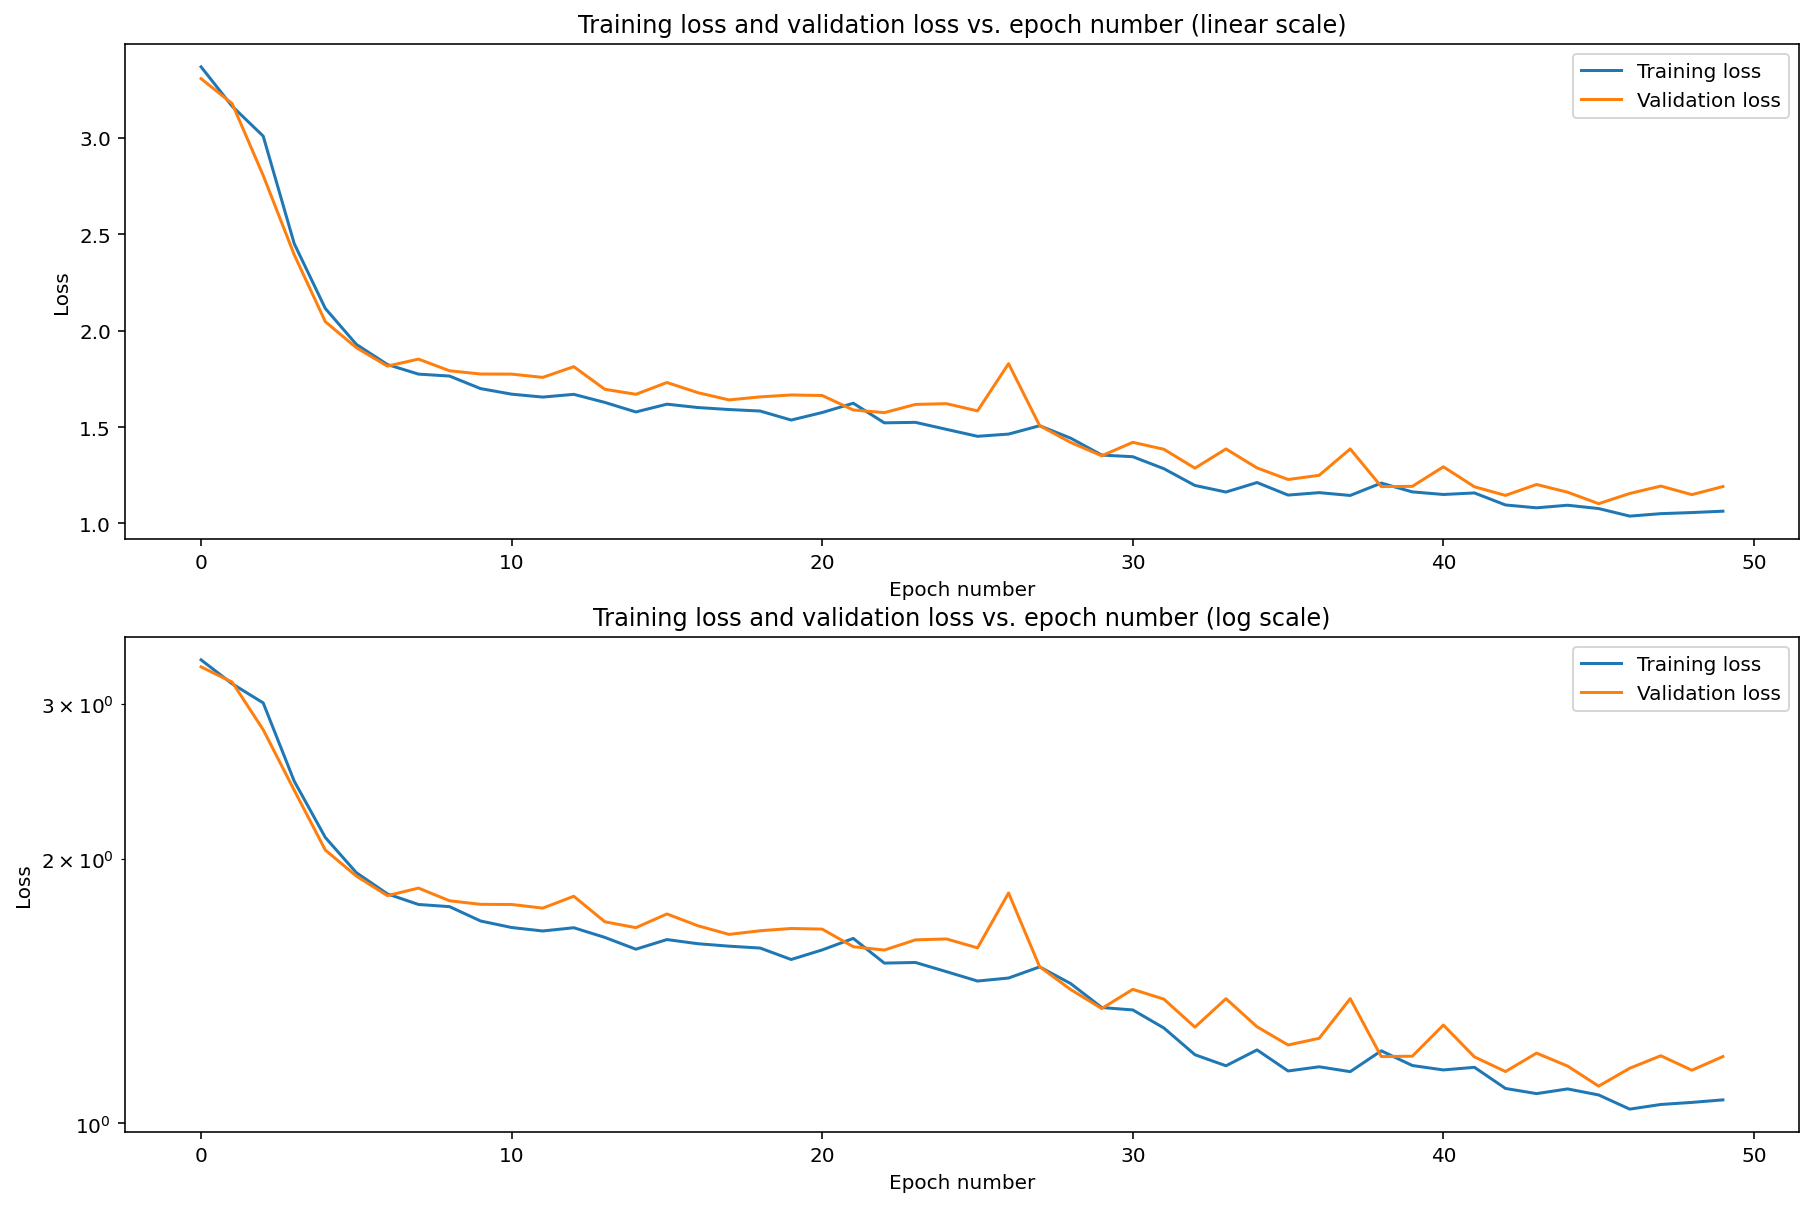

In [13]:
# model name and path

import os

#@markdown ###The path to the model folder:

QC_model_folder = "/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/models/Fishn32e50s10resize5" #@param {type:"string"}

#Here we define the loaded model name and path
QC_model_name = os.path.basename(QC_model_folder)
QC_model_path = os.path.dirname(QC_model_folder)


full_QC_model_path = QC_model_path+'/'+QC_model_name+'/'
if os.path.exists(full_QC_model_path):
  print("The "+QC_model_name+" network will be evaluated")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

lossDataFromCSV = []
vallossDataFromCSV = []

with open(QC_model_path+'/'+QC_model_name+'/Quality Control/training_evaluation.csv','r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()


plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.savefig(QC_model_path+'/'+QC_model_name+'/Quality Control/lossCurvePlots.png')
plt.show()

## **8.2. Error mapping and quality metrics estimation (Optional)**
---
<font size = 4>This section will calculate the Intersection over Union score for all the images provided in the Source_QC_folder and Target_QC_folder ! The result for one of the image will also be displayed.

<font size = 4>The **Intersection over Union** metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict nuclei. 

<font size = 4> The results can be found in the "*Quality Control*" folder which is located inside your "model_folder".

Number of test dataset found in the folder: 20
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.519748, nms_thresh=0.3.
Running QC on: 07.tif
Running QC on: 08.tif
Running QC on: 15.tif
Running QC on: 06.tif
Running QC on: 09.tif
Running QC on: 03.tif
Running QC on: 17.tif
Running QC on: 18.tif
Running QC on: 13.tif
Running QC on: 10.tif
Running QC on: 16.tif
Running QC on: 12.tif
Running QC on: 01.tif
Running QC on: 05.tif
Running QC on: 20.tif
Running QC on: 19.tif
Running QC on: 04.tif
Running QC on: 11.tif
Running QC on: 02.tif
Running QC on: 14.tif


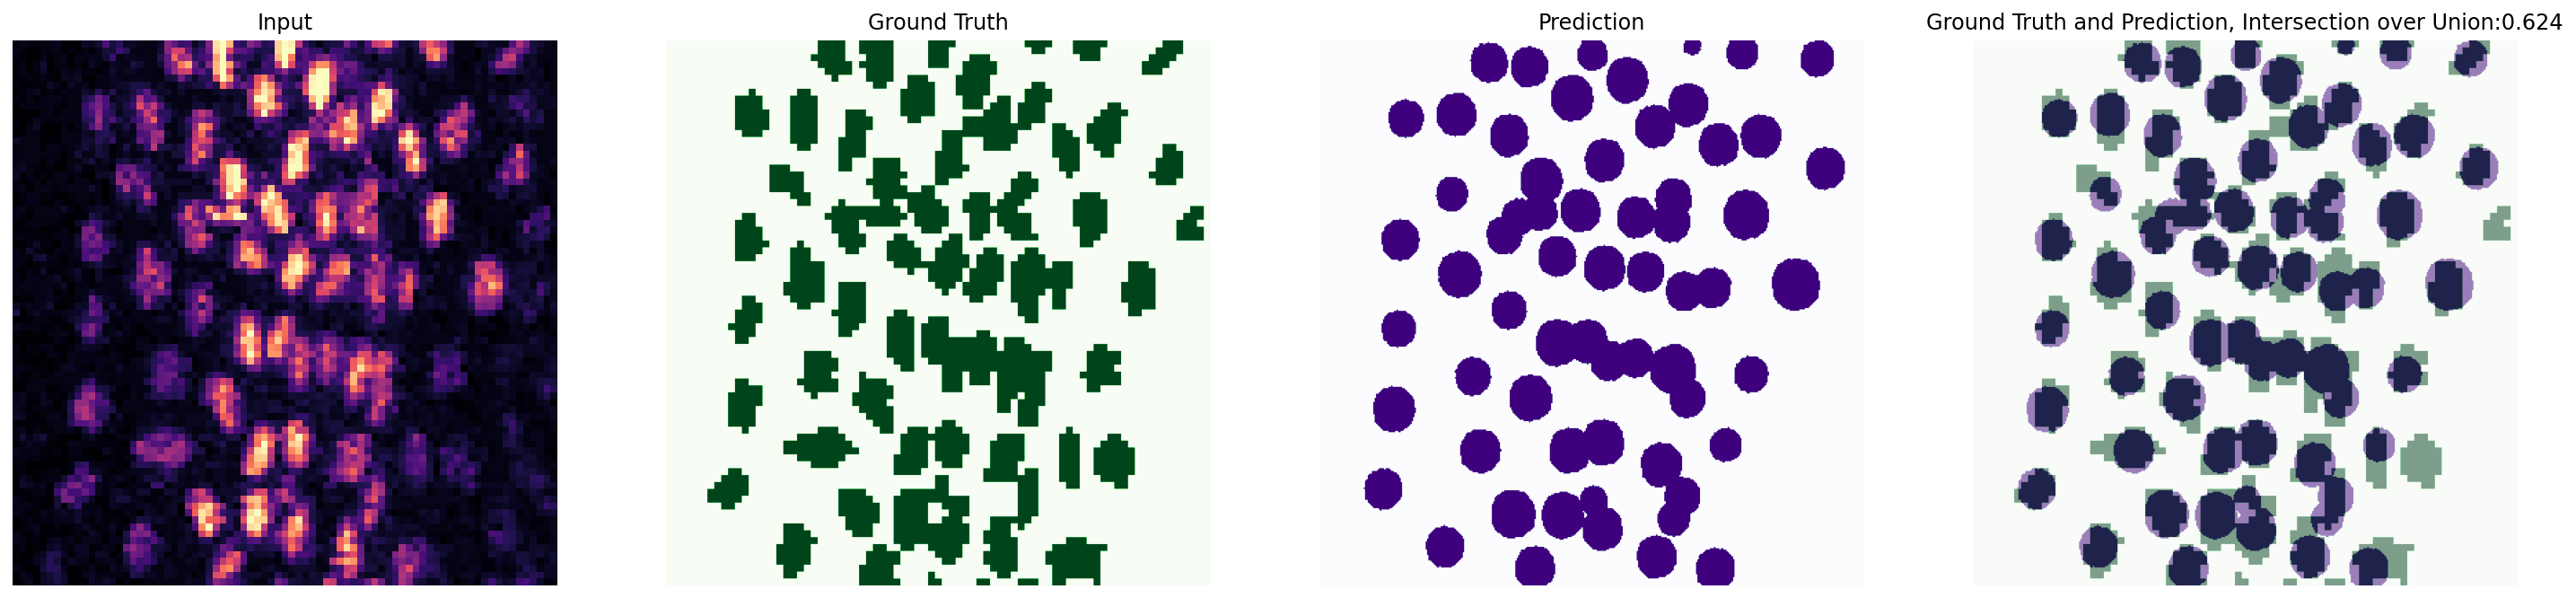

In [14]:
#@markdown ##Choose the folders that contain your Quality Control dataset

Source_QC_folder = "/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/images" #@param{type:"string"}
Target_QC_folder = "/content/gdrive/My Drive/Colab Notebooks/2D/dataMY5times/train/masks" #@param{type:"string"}


#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control") == False:
  os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control")

if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")


# Generate predictions from the Source_QC_folder and save them in the QC folder

Source_QC_folder_tif = Source_QC_folder+"/*.tif"

np.random.seed(16)
lbl_cmap = random_label_cmap()
Z = sorted(glob(Source_QC_folder_tif))
Z = list(map(imread,Z))
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently

print('Number of test dataset found in the folder: '+str(len(Z)))
  
  # axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
  print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

model = StarDist2D(None, name=QC_model_name, basedir=QC_model_path)

names = [os.path.basename(f) for f in sorted(glob(Source_QC_folder_tif))]

 
# modify the names to suitable form: path_images/image_numberX.tif
  
lenght_of_Z = len(Z)
  
for i in range(lenght_of_Z):
  img = normalize(Z[i], 1,99.8, axis=axis_norm)
  labels, polygons = model.predict_instances(img)
  os.chdir(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")
  imsave(names[i], labels, polygons)


# Here we start testing the differences between GT and predicted masks


with open(QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["image","Prediction v. GT Intersection over Union"])  

# define the images

  for n in os.listdir(Source_QC_folder):
    
    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = io.imread(os.path.join(Source_QC_folder,n))
      test_prediction = io.imread(os.path.join(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction",n))
      test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255

      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score)])


#Display the last image

f = plt.figure(figsize=(25,25))

from astropy.visualization import simple_norm
norm = simple_norm(test_input, percent = 99)

#Input
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(test_input, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
plt.title('Input')


#Ground-truth
plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(test_ground_truth_0_to_255, aspect='equal', cmap='Greens')
plt.title('Ground Truth')

#Prediction
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(test_prediction_0_to_255, aspect='equal', cmap='Purples')
plt.title('Prediction')

#Overlay
plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(test_ground_truth_0_to_255, cmap='Greens')
plt.imshow(test_prediction_0_to_255, alpha=0.5, cmap='Purples')
plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3)));
